## Create galaxy and display it

In [74]:
#chdir to where we can import packages.
import os
os.getcwd()
os.chdir("/Users/Ismael/code/research/repo")
os.getcwd()

#ignore warning below

'/Users/Ismael/code/research/repo'

In [79]:
#other packages to import in repo 
import fisher
import galfun
import galsim
import sys
import copy
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab

In [38]:
project_name = "project2"

In [39]:
%%bash 
#create project with galaxy and draw image to create an info file. 
python generate.py -p project2 -gal 1 --psf_model gaussian --galaxy-model gaussian --e1 .2 --e2 0. --y0 0 --x0 0 \
--flux 1. --psf_flux 1. --hlr .5 --psf_fwhm .7
python display.py -p project2 --snr 60 -d --hide

In [40]:
#read galaxy from project1 and create fisher object.
snr = 60
g_parameters = galfun.GParameters(project_name)
fish = fisher.Fisher(g_parameters, snr)

In [41]:
%%bash 
#show info file.
cat project2/info.txt

Default values used in the analysis:
nx: 48
ny: 48
pixel_scale: 0.2

Galaxies drawn have the following parameters:
x0_1: 0.0
psf_fwhm_1: 0.7
hlr_1: 0.5
e2_1: 0.0
galaxy_model_1: gaussian
psf_flux_1: 1.0
flux_1: 1.0
e1_1: 0.2
psf_model_1: gaussian
y0_1: 0.0
the results were produced with:
/Users/Ismael/code/research/repo

Fisher analysis (and fittings if included) used the following snr: 60.0

Steps used for the derivatives: 
hlr_1: 0.005
e2_1: 0.01
x0_1: 0.01
flux_1: 0.01
e1_1: 0.01
y0_1: 0.01

Condition number of Fisher Matrix:
35.9698393932


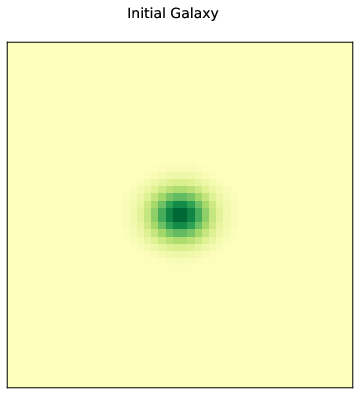

In [66]:
from wand.image import Image as WImage
img = WImage(filename='project2/plots/figure1.pdf')
img

### Shear functions

In [59]:
#get bias of shear with ring test

def shearEllipticity(g, e):
    """Changes given ellipticity to a sheared ellpticity according to the
    formula (14) of paper: http://arxiv.org/abs/1409.6273.
    Ellipticity should be given by inputting the two components.
    Returns both sheared components of ellpicity.
    Uses complex numbers.
    """
    e_s = (e + g)/(1 + g.conjugate()*e)
    return e_s

def residual_shear(x, m, a):
    return m*x + a

def shearBias(fish, g):
    """Returns the value of the bias of the given lensing shear for the
    particular galaxy analyzed by using the ring test. Only works with
    a single galaxy profile.
    Assume galaxy is parametrized with e1,e2.
    """
    angle_range = (0, 2*math.pi)
    steps = 7 #6 points on the ring. excluding theta=2pi
    id_params = copy.deepcopy(fish.g_parameters.id_params)
    ids = id_params.keys()
    id1 = ids[0]
    snr = fish.snr
    angles = list(np.linspace(angle_range[0], angle_range[1], steps))
    angles.pop() #remove 2pi angle redundancy.
    ellipticities_s = [] #for sanity check.
    biases = []
    orig_e1 = id_params[id1]['e1']
    orig_e2 = id_params[id1]['e2']
    orig_e = complex(orig_e1,orig_e2) #unsheared ellipticity
    for angle in angles:
        e = complex(abs(orig_e)*math.cos(angle),abs(orig_e)*math.sin(angle))
        e_s = shearEllipticity(g, e) #get sheared components
        ellipticities_s.append(e_s)

        id_params[id1]['e1'] = e_s.real
        id_params[id1]['e2'] = e_s.imag
        g_parameters = galfun.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters, snr)
        bias = complex(fish.biases['e1_'+id1],fish.biases['e2_'+id1])
        biases.append(bias)

    #sanity check.
    #print np.mean(ellipticities_s)

    #return bias(g) which is average of ellipticity bias
    return np.mean(biases)


### Sanity check 

In [60]:

#######only for sanity check discard later.

def sheared_ellipticies(fish, g):
    """Returns the value of the bias of the given lensing shear for the
    particular galaxy analyzed by using the ring test. Only works with
    a single galaxy profile.
    Assume galaxy is parametrized with e1,e2.
    """
    angle_range = (0, 2*math.pi)
    steps = 7 #6 points on the ring. excluding theta=2pi
    id_params = copy.deepcopy(fish.g_parameters.id_params)
    ids = id_params.keys()
    id1 = ids[0]
    snr = fish.snr
    angles = list(np.linspace(angle_range[0], angle_range[1], steps))
    angles.pop() #remove 2pi angle redundancy.
    ellipticities_s = [] #for sanity check.
    biases = []
    orig_e1 = id_params[id1]['e1']
    orig_e2 = id_params[id1]['e2']
    orig_e = complex(orig_e1,orig_e2) #unsheared ellipticity
    for angle in angles:
        e = complex(abs(orig_e)*math.cos(angle),abs(orig_e)*math.sin(angle))
        e_s = shearEllipticity(g, e) #get sheared components
        ellipticities_s.append(e_s)

        id_params[id1]['e1'] = e_s.real
        id_params[id1]['e2'] = e_s.imag
        g_parameters = galfun.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters, snr)
        bias = complex(fish.biases['e1_'+id1],fish.biases['e2_'+id1])
        biases.append(bias)

    return ellipticities_s


In [61]:
#make sure average of sheared ellipticities in the ring equals the shear.
g = .01
print np.mean(sheared_ellipticies(fish, g))
print g 



(0.00999999999999+1.38777878078e-17j)
0.01


### Some bias examples

In [62]:
g1 = .0001
print shearBias(fish, g1)

g2 = .02
print shearBias(fish, g2)

g3 = .2 + .2j
print shearBias(fish, g3)

(-2.52184690908e-08-2.41784196831e-11j)
(-2.58368757689e-05-1.48511509803e-11j)
(-0.000245006721646-0.000244959584961j)


### Getting multiplicative and additive bias

In [97]:
#get multiplicative and additive biases of shear by doing a linear fit.
def getMultAddBias(fish):
    g_range = (.0001, .02)
    steps = 5
    g_ranges = list(np.linspace(g_range[0], g_range[1], steps))
    gs = []
    bs = []
    g2 = 0
    #assume g2 = 0 for now. 
    for g1 in g_ranges:
        g = complex(g1,g2)
        b = shearBias(fish, g)
        gs.append(g)
        bs.append(b)
    gs_real = np.array([g.real for g in gs])
    gs_imag = np.array([g.imag for g in gs])
    bs_real = np.array([b.real for b in bs])
    bs_imag = np.array([b.imag for b in bs])
     
    return (gs_real, bs_real, gs_imag, bs_imag)
#     x0 = np.array([0.,0.])
#     y0 = np.array([0.,0.])
#     print scipyopt.curve_fit(residual_shear,gs_real, bs_real, x0)
#     print scipyopt.curve_fit(residual_shear,gs_imag, bs_imag, y0)

<Container object of 3 artists>

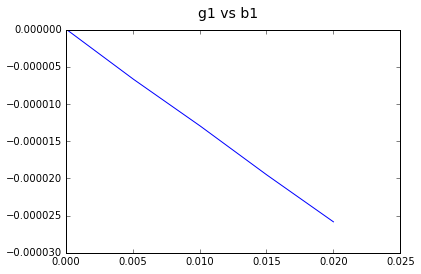

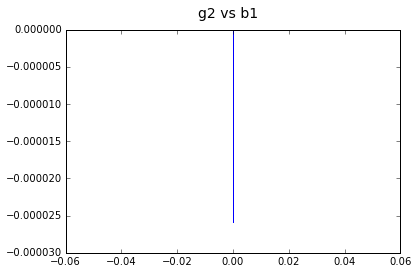

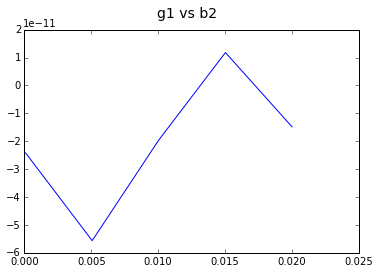

In [98]:
(gs_real, bs_real, gs_imag, bs_imag) = getMultAddBias(fish)

#plot this.

figure = plt.figure()
figure.suptitle('g1 vs b1', fontsize=14)
ax = figure.add_subplot(111)
ax.errorbar(gs_real, bs_real)

figure = plt.figure()
figure.suptitle('g2 vs b1', fontsize=14)
ax = figure.add_subplot(111)
ax.errorbar(gs_imag, bs_real)

figure = plt.figure()
figure.suptitle('g1 vs b2', fontsize=14)
ax = figure.add_subplot(111)
ax.errorbar(gs_real, bs_imag)


